In [16]:
import ollama
import csv

import random
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt

## Prompt
You are a linguistic expert evaluating the interpretability of two datasets. 

Evaluate the interpretability of the two sets of words below. A set is more interpretable if it reflects clear semantic patterns or categories, has meaningful diversity, and maintains contextual coherence across the words. Consider repetition only if it highlights important linguistic patterns. Choose the set that better meets these criteria


Dataset 1: {dataset1} 

Dataset 2: {dataset2}

Which dataset is more interpretable?

Respond ONLY with the dataset number  "1" or "2"

In [3]:
# crea un objeto con numero de fila original, peso y texto
class Dataset:
    def __init__(self, Originalindex, weight, text):
        self.Originalindex = Originalindex
        self.weight = weight
        self.text = text

In [28]:
df = pd.read_csv('tokens_mlp.csv')
df.columns = ['Words', 'Original Index']

In [29]:
i=0
filas = []
for w in df['Words']:
    vector = ast.literal_eval(w)

    resultado = " ".join([s.strip() if isinstance(s, str) else str(s) for s in vector])
    filas.append(Dataset(i, 5, resultado))
    
    i += 1

In [33]:
for f in filas:
    print(f.text)

ays ays stuck stuck stuck stuck objects objects ays stuck
Tree pin ony ony creatures break break pin Rip Rip
should should correspondence would would would studies studies , ,
Cab Raf Raf those those Cab Cab Cab Raf Raf
will will would would would will will to to must
Hugh Hugh Hugh Mr Mr Hugh Hugh Hugh Hugh Hugh
till @ March ・ ・ Ad ・ ・ ・ ・
crust crust moment uprising moment moment lines lines moment moment
AT AT AT AT AT AT AT AT AT AT
mentions mentions mentions mentions resembled mentions mentions resembled comprise mentions
itism reconstruction reconstruction itism itism tactics tactics ) ) )
ineries clocks apparatus apparatus chapel chapel pistol pistol chambers chapel
In In In In In In In In In In
Sof Fab Merc Merc Stab Stab Sof Fab Fab Alberta
IV IV IV IV IV IV Exile IV IV 21
John John 21 res London Grey Grey 81 81 dt
medicine medicine rolls rolls Marketing Marketing replication execution execution fit
pig pig ye blues blues pig O O O cat
remarked remarked remarked remarked remar

In [34]:
def more_interpretable(dataset1, dataset2):
    return ollama.generate(
        model='gemma2:9b', 
        options={'temperature': 0.001},
        system = '''You are a linguistic expert evaluating the interpretability of two datasets. 
        Evaluate the interpretability of the two sets of words below. A set is more interpretable if it reflects clear semantic patterns or categories, has meaningful diversity, and maintains contextual coherence across the words. Consider repetition only if it highlights important linguistic patterns. Choose the set that better meets these criteria
        ''',    
        prompt=f'''        
        Dataset 1: {dataset1}
        Dataset 2: {dataset2}

        Which dataset is more interpretable?
        Respond ONLY with the dataset number  "1" or "2"
    ''')['response']
     

In [35]:
def Compara_interpretabilidad(filas):
    # hace un shuffle de las filas
    random.shuffle(filas)
    # Aplicar el método de burbuja para ordenar por interpretabilidad
    n = len(filas)
    for i in range(n-1):    
        # Si la fila actual es menos interpretable que la siguiente, le resto 1 al peso
        comparacion = more_interpretable(filas[i].text, filas[i+1].text)
        # si la variable comparacion contiene el caracter '2' la fila i le resto 1 al peso, si contiene 1 le resto 1 al peso de la fila i+1
        if comparacion.find('2') != -1:
            filas[i].weight -= 1
        else:
            filas[i+1].weight -= 1
    return 


In [36]:
def genera_top_k(filas, k):
    #mientras haya mas k filas 
    while len(filas) > k:
        print(len(filas))
        Compara_interpretabilidad(filas)
        # ordenar las filas por peso de mayor a menor
        filas.sort(key=lambda x: x.weight, reverse=True)        
        # elimino las filas con peso <= 0 a menos que sean las primeras k filas de la lista
        filas = [x for i, x in enumerate(filas) if x.weight > 0 or i < k]
    return filas

In [37]:
filas = genera_top_k(filas, 40)

127
127
127
95
67
45


In [38]:
filas.sort(key=lambda x: x.weight, reverse=True)        
# imprimo el detalle de todas las fials
for fila in filas:
    print(fila.Originalindex, fila.weight, fila.text)
    

98 5 submarines boats planes planes carriers carriers prisoners prisoners trucks carriers
48 5 bush bush sport bush harness fox bush bush sport sport
41 5 ritual restoration church church reconstruction column story stabilization garrison garrison
35 5 tactics resources resources commitment commitment tactics commitment techniques techniques honor
79 4 colonies colonies located located formed formed formed formed stretched stretched
43 4 broadcasts broadcasts summarizes summarizes deforestation deforestation blessing blessing working working
54 4 disrupt disrupt disrupt inject inject inject inject affect inhibits inhibits
66 4 away migration migration unaffected unaffected breeding breeding breeding breeding expelled
88 4 vector vector Command Command judicial judicial judicial erect Principles Principles
74 4 encompass encompass used used occupies occupies utilized used used utilized
107 4 medicine lakes aks aks ales ales ales swimming swimming lakes
85 3 objects objects objects objec

In [39]:
df = pd.DataFrame({
    "Indices Originales": [x.Originalindex for x in filas],
    "Words": [x.text for x in filas]
})

output_csv_path = "interpretable_tokens_mlp.csv"
df.to_csv(output_csv_path, index=False, header=False)

________

In [40]:
df_interpretables_autoencoder = pd.read_csv('interpretable_tokens.csv')
df_interpretables_autoencoder.columns = ['Original Index', 'Words']


df_interpretables_mlp = pd.read_csv('interpretable_tokens_mlp.csv')
df_interpretables_mlp.columns = ['Original Index', 'Words']


In [41]:
def scoring_interpretability(dataset):
    return ollama.generate(
            model='gemma2:9b', 
            options={'temperature': 0.001},
            system = '''You are a linguistic expert evaluating the interpretability of different datasets. 
            A set is more interpretable if it reflects clear semantic patterns or categories, 
            has meaningful diversity, and maintains contextual coherence across the words. 
            Consider repetition only if it highlights important linguistic patterns.
            Generate an integer score for the interpretability of the dataset. The score should be between 0 and 7, where 0 is not interpretable and 20 is highly interpretable.
            ''',
            prompt=f'''
            Generate 1 integer. Only include the number, do not include any letters and space. Do not include \r or \n
            1 - score for the interpretability of the dataset between 0 and 7.
            
            The format should be:
            interpretability_score

            Example:
            Dataset: "['tissues',  'plants', 'proteins', 'bacteria', 'bacteria', 'proteins', 'proteins', 'proteins', 'proteins', 'genes']"
            Response:
            '7'

            Dataset: {dataset}

            
        ''')['response']

In [42]:
scores_autoencoder = []
for w in (df_interpretables_autoencoder['Words']):
    s = int(scoring_interpretability(w))
    scores_autoencoder.append(s)

In [43]:
scores_mlp = []
for w in (df_interpretables_mlp['Words']):
    s = int(scoring_interpretability(w))
    scores_mlp.append(s)

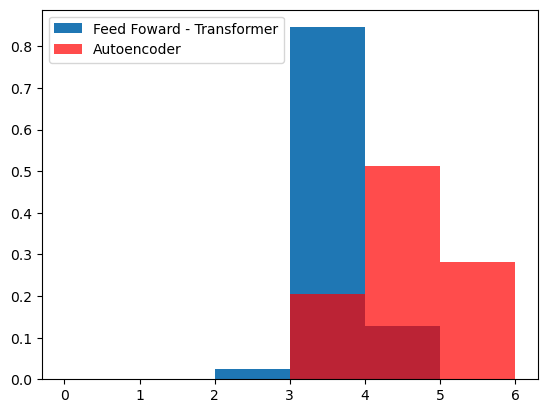

In [46]:
plt.hist(scores_mlp, density=True,  bins= np.arange(7), label='Feed Foward - Transformer')
plt.hist(scores_autoencoder, alpha = 0.7, color='red', density= True,  bins= np.arange(7), label='Autoencoder')
plt.legend()
plt.show()

In [54]:
id_feature = 643
df_print = pd.read_csv(f'./activations_data/activations_data/activations_feature_{id_feature}.csv')
df_print.columns = ['Activacion','Tokens Id','Context']

df_print

,Activacion,Tokens Id,Context
0,0.999605,schools,"the storm caused flooding in Kauai , nearly 1..."
1,0.953592,houses,precipitation flooded many buildings across t...
2,0.940686,families,"sent food , water , and housing supplies to a..."
3,0.939636,houses,", and coffee to many affected houses . Damage..."
4,0.939636,houses,", and coffee to many affected houses . Damage..."
5,0.938735,installations,connecting flights on helicopters to offshore...
6,0.938735,installations,connecting flights on helicopters to offshore...
7,0.928946,flags,", and when he was in a carriage . The imperia..."
8,0.928946,flags,", and when he was in a carriage . The imperia..."
9,0.924531,relocate,to relocate further south to Blue Earth but c...
